In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd



In [ ]:
# Standard MNIST transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.9MB/s]


In [ ]:
class CNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU(), dropout_rate=0.25, use_bn=True):
        super(CNN, self).__init__()

        # Base Architecture [cite: 12]
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3), # Conv2D Layer 1 [cite: 12]
            activation_fn,
            nn.Conv2d(32, 64, kernel_size=3), # Conv2D Layer 2 [cite: 12]
            activation_fn,
            nn.MaxPool2d(2), # Max Pooling [cite: 12]
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity() # Dropout [cite: 13]
        )

        # Dense Layers [cite: 14]
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 128),
            nn.BatchNorm1d(128) if use_bn else nn.Identity(),
            activation_fn,
            nn.Linear(128, 10) # Output Layer (Softmax applied by CrossEntropyLoss) [cite: 14]
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)

In [ ]:
def run_experiment(name, activation, opt_type, epochs=10, dropout=0.25, bn=True):
    model = CNN(activation_fn=activation, dropout_rate=dropout, use_bn=bn).to(device)
    criterion = nn.CrossEntropyLoss()

    # Optimizer Selection [cite: 31, 32]
    if opt_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif opt_type == "Momentum":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else: # Adam [cite: 35]
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {'loss': [], 'accuracy': []}

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Quick Test after each epoch
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        history['accuracy'].append(acc)
        history['loss'].append(loss.item())

    return acc, history

# --- Task 1 & 2 Execution ---
results_table = []

# Example: Running the required table experiments [cite: 43, 44]
configs = [
    ("Exp 1", nn.Sigmoid(), "SGD"),
    ("Exp 2", nn.ReLU(), "SGD"),
    ("Exp 3", nn.ReLU(), "Adam")
]

all_histories = {}
for name, act, opt in configs:
    final_acc, hist = run_experiment(name, act, opt)
    all_histories[name] = hist
    results_table.append({"Experiment": name, "Activation": act.__class__.__name__,
                          "Optimizer": opt, "Final Accuracy": f"{final_acc}%"})

  Experiment Activation Optimizer Final Accuracy
0      Exp 1    Sigmoid       SGD         95.55%
1      Exp 2       ReLU       SGD         99.19%
2      Exp 3       ReLU      Adam         99.24%


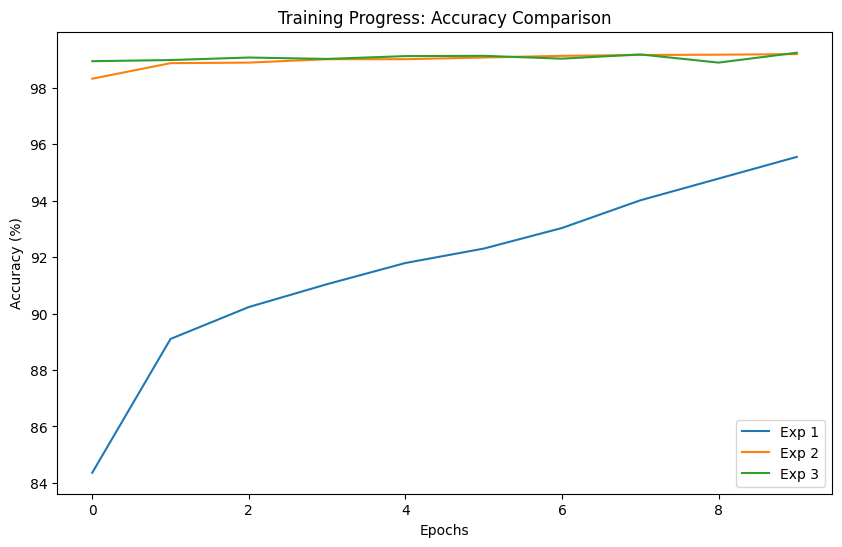

In [ ]:
# Display Comparison Table [cite: 43]
df = pd.DataFrame(results_table)
print(df)

# Plotting Accuracy Curves [cite: 42]
plt.figure(figsize=(10, 6))
for name, hist in all_histories.items():
    plt.plot(hist['accuracy'], label=name)
plt.title("Training Progress: Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [ ]:
run_experiment("Task 3a", nn.ReLU(), "Adam", dropout=0, bn=False)


(98.88,
 {'loss': [0.016751276329159737,
   0.05605729669332504,
   0.0015764859272167087,
   0.007151959463953972,
   0.0030124448239803314,
   0.0024329638108611107,
   0.0003270241431891918,
   0.0002913251519203186,
   0.0001555154158268124,
   0.0013352594105526805],
  'accuracy': [98.34,
   98.99,
   98.57,
   99.04,
   98.98,
   99.0,
   99.0,
   98.96,
   98.89,
   98.88]})

In [ ]:
run_experiment("Task 3b", nn.ReLU(), "Adam", dropout=0.1, bn=False)

(98.88,
 {'loss': [0.013748273253440857,
   0.006055602338165045,
   0.09064088761806488,
   0.0003182536456733942,
   8.291342237498611e-05,
   2.5175897462759167e-05,
   0.0021754747722297907,
   0.0007175693172030151,
   0.08365001529455185,
   7.147437281673774e-05],
  'accuracy': [98.57,
   98.75,
   98.82,
   99.06,
   98.95,
   98.96,
   98.83,
   98.67,
   99.14,
   98.88]})

In [ ]:
class MLP(nn.Module):
    def __init__(self, hidden_layers=[256, 128], use_bn=True):
        super(MLP, self).__init__()

        layers_list = []
        input_dim = 784  # 28*28 flattened [cite: 16]

        for h_dim in hidden_layers:
            layers_list.append(nn.Linear(input_dim, h_dim)) # Dense layer [cite: 17, 20]
            if use_bn:
                layers_list.append(nn.BatchNorm1d(h_dim)) # BatchNormalization [cite: 18, 21]
            layers_list.append(nn.ReLU()) # ReLU Activation [cite: 19, 22]
            input_dim = h_dim

        # Final Output Layer
        layers_list.append(nn.Linear(input_dim, 10)) # Dense(10, Softmax) [cite: 24]

        self.model = nn.Sequential(*layers_list)

    def forward(self, x):
        x = x.view(-1, 784) # Flatten(784) [cite: 16]
        return self.model(x)

In [ ]:
def run_mlp_experiment(name, hidden_dims, opt_type, epochs):
    print(f"\n--- Running Experiment: {name} ---")
    model = MLP(hidden_layers=hidden_dims).to(device)
    criterion = nn.CrossEntropyLoss()

    if opt_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Execute training and get history
    history = train_with_metrics(model, train_loader, test_loader, criterion, optimizer, epochs)

    # Extract final accuracy from history
    final_accuracy = history['test_acc'][-1]
    return f"{final_accuracy:.2f}%", history

# Table requirements
mlp_configs = [
    {"name": "MLP-1", "layers": [512, 256, 128], "opt": "SGD", "epochs": 20},
    {"name": "MLP-2", "layers": [256], "opt": "Adam", "epochs": 15}
]

In [ ]:
import matplotlib.pyplot as plt

def train_with_metrics(model, train_loader, test_loader, criterion, optimizer, epochs):
    history = {'train_loss': [], 'test_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate Average Train Loss for the epoch
        avg_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_loss)

        # Calculate Test Accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                # Fix: Changed `images, labels = images.to(device), labels.size(0), labels.to(device)`
                # to `images, labels = images.to(device), labels.to(device)`
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        history['test_acc'].append(test_acc)
        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}, Acc {test_acc:.2f}%")

    return history

# --- Visualization for Task 3 ---
def plot_comparisons(all_histories):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for name, hist in all_histories.items():
        # Plot 1: Training Loss (Task 1 & 2 observation)
        ax1.plot(hist['train_loss'], label=f'{name} Loss')
        # Plot 2: Test Accuracy (Comparison Table requirement)
        ax2.plot(hist['test_acc'], label=f'{name} Acc')

    ax1.set_title('Training Loss Curves')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title('Testing Accuracy Curves')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()


--- Running Experiment: MLP-1 ---
Epoch 1: Loss 0.4117, Acc 96.08%
Epoch 2: Loss 0.1434, Acc 97.24%
Epoch 3: Loss 0.0940, Acc 97.59%
Epoch 4: Loss 0.0680, Acc 97.97%
Epoch 5: Loss 0.0510, Acc 98.03%
Epoch 6: Loss 0.0402, Acc 98.19%
Epoch 7: Loss 0.0318, Acc 98.23%
Epoch 8: Loss 0.0262, Acc 98.12%
Epoch 9: Loss 0.0212, Acc 98.23%
Epoch 10: Loss 0.0176, Acc 98.29%
Epoch 11: Loss 0.0148, Acc 98.16%
Epoch 12: Loss 0.0134, Acc 98.20%
Epoch 13: Loss 0.0115, Acc 98.24%
Epoch 14: Loss 0.0097, Acc 98.22%
Epoch 15: Loss 0.0088, Acc 98.12%
Epoch 16: Loss 0.0085, Acc 98.30%
Epoch 17: Loss 0.0072, Acc 98.14%
Epoch 18: Loss 0.0060, Acc 98.35%
Epoch 19: Loss 0.0059, Acc 98.36%
Epoch 20: Loss 0.0054, Acc 98.32%

--- Running Experiment: MLP-2 ---
Epoch 1: Loss 0.2246, Acc 96.75%
Epoch 2: Loss 0.1000, Acc 97.51%
Epoch 3: Loss 0.0692, Acc 97.78%
Epoch 4: Loss 0.0525, Acc 97.77%
Epoch 5: Loss 0.0400, Acc 97.81%
Epoch 6: Loss 0.0331, Acc 98.05%
Epoch 7: Loss 0.0267, Acc 97.82%
Epoch 8: Loss 0.0238, Acc 98

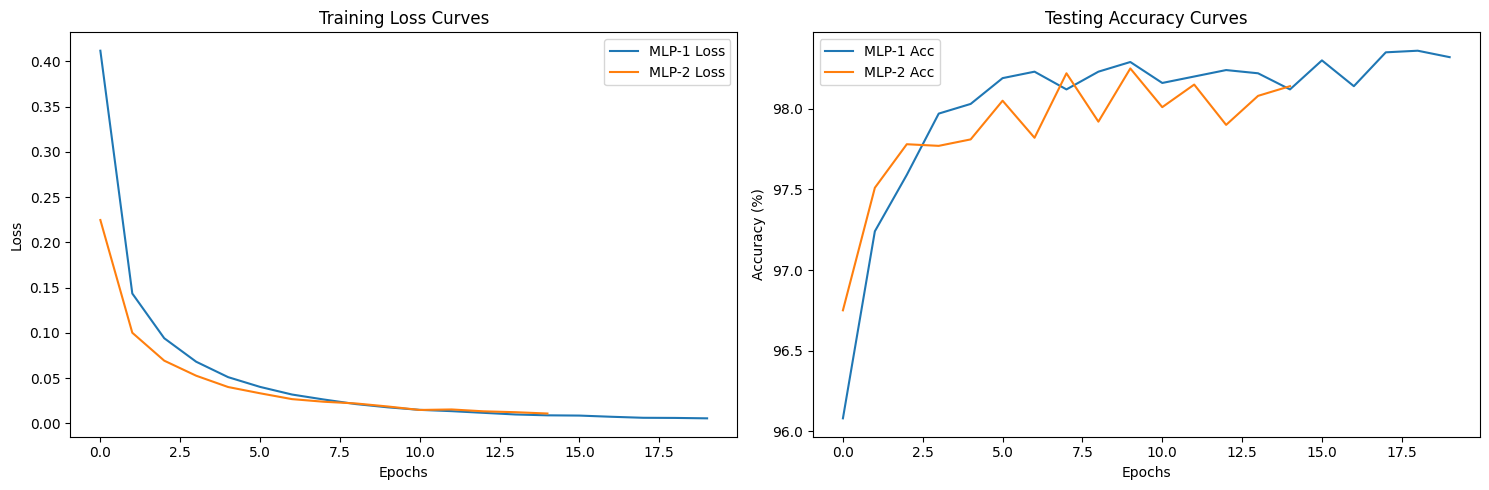

In [ ]:
final_results = []
all_histories = {}

for config in mlp_configs:
    acc_str, hist = run_mlp_experiment(config['name'], config['layers'], config['opt'], config['epochs'])
    all_histories[config['name']] = hist
    final_results.append({
        "Model": config['name'],
        "FC layer": "-".join(map(str, config['layers'])),
        "Optimizer": config['opt'],
        "Epochs": config['epochs'],
        "Accuracy": acc_str
    })

# Output the Comparison Table
print("\n" + "="*30)
print("FINAL COMPARISON TABLE")
print("="*30)
print(pd.DataFrame(final_results))

# Show Plots
plot_comparisons(all_histories)